In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-01_10-46_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.055293005671077505

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

YM       0.25
GC       0.25
ES       0.25
NQ       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    27829.20
GC     9218.28
NQ    37839.80
YM    36911.60
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

111798.88

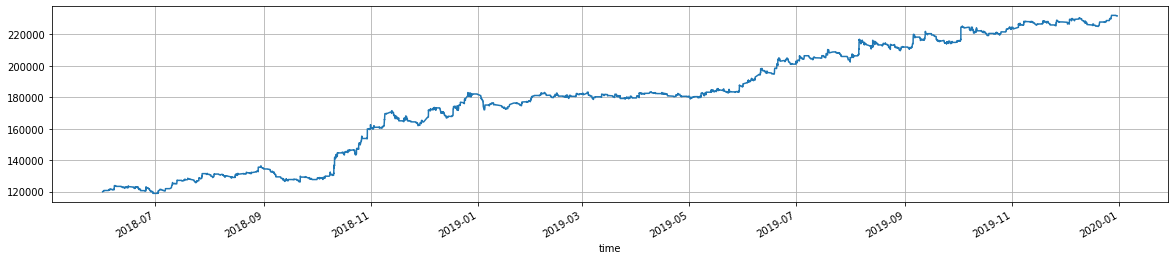

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     498
 GC    1167
 NQ    2013
 YM     554
 Name: action, dtype: int64,
 4232)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.208738
 GC    2.832524
 NQ    4.885922
 YM    1.344660
 Name: action, dtype: float64,
 10.271844660194175)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1045.80
GC    2824.14
NQ    4227.30
YM    1163.40
Name: commission, dtype: float64

In [16]:
df.commission.sum()

9260.64

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.37,15.81,489.06,-266.84,1.83,12.84,583.0
NQ,0.40,37.61,464.96,-247.99,1.87,37.19,1006.0
ES,0.43,111.76,947.19,-528.14,1.79,106.25,249.0
YM,0.44,133.25,757.37,-350.83,2.16,136.78,277.0
total,0.40,52.86,574.04,-297.34,1.93,51.21,2115.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.026082,0.181018,0.565283,0.710825
GC,-0.026082,1.000000,0.110570,0.055858,0.411114
NQ,0.181018,0.110570,1.000000,0.237484,0.640293
YM,0.565283,0.055858,0.237484,1.000000,0.731672
total,0.710825,0.411114,0.640293,0.731672,1.000000


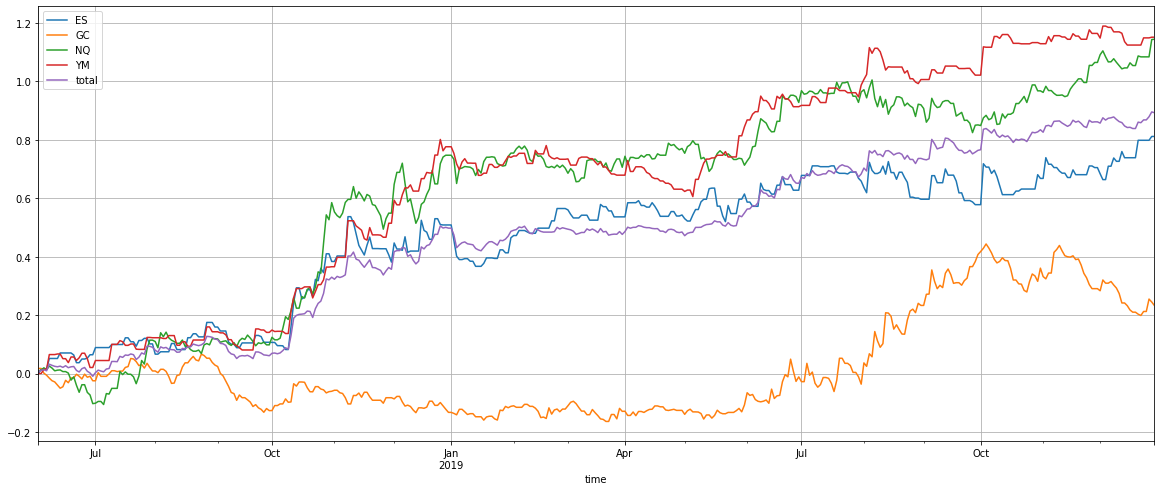

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

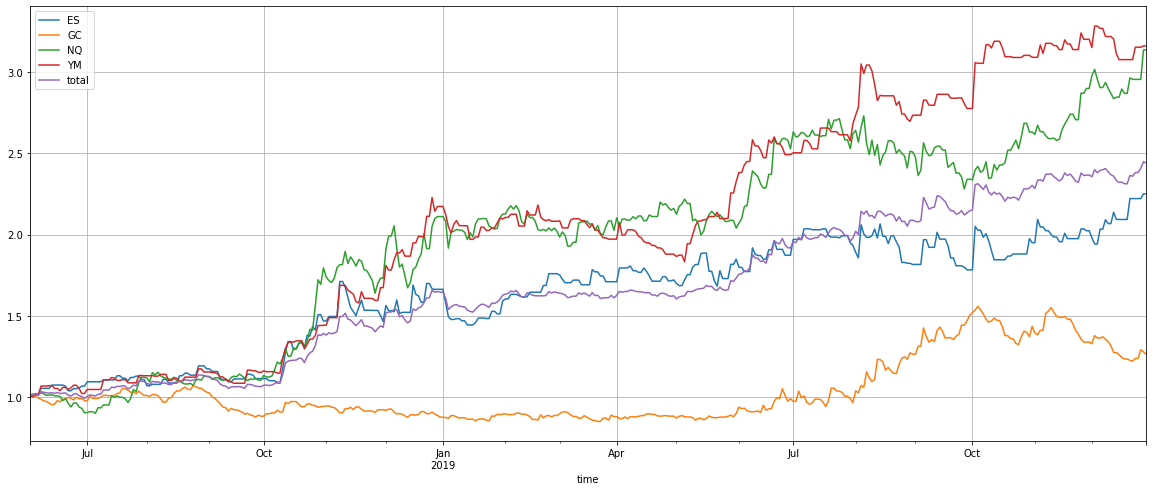

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.642573,0.152799,1.013226,1.021956,0.726188
Cumulative returns,1.250949,0.261718,2.139354,2.161639,1.441294
Annual volatility,0.382818,0.306090,0.379344,0.313392,0.218410
Sharpe ratio,1.482146,0.614021,2.033753,2.401355,2.609079
Calmar ratio,4.110574,0.703587,5.448521,5.751285,8.910620
Stability,0.862722,0.395883,0.858071,0.927960,0.954282
Max drawdown,-0.156322,-0.217172,-0.185964,-0.177692,-0.081497
Omega ratio,1.434714,1.126401,1.461997,1.812226,1.685163
Sortino ratio,3.075589,1.146659,3.591931,5.565828,5.731394
Skew,2.149953,1.757580,0.775795,2.223920,1.930642


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,6.63,-2.46,-9.80,2.08,-0.95
2018-07-31,3.78,3.41,24.28,10.73,10.44
2018-08-31,5.95,2.04,0.52,2.06,2.82
2018-09-30,-5.08,-14.42,-2.11,-0.21,-5.52
2018-10-31,31.85,6.84,62.72,25.19,30.85
2018-11-30,-0.22,-2.18,-3.54,16.06,2.74
2018-12-31,13.56,-4.89,21.93,29.92,15.13
2019-01-31,-4.29,2.09,0.73,-3.58,-1.08
2019-02-28,10.54,-0.93,-5.03,-0.64,0.97


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       125.0
GC        26.0
NQ       214.0
YM       216.0
total    144.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:49:00,ES,BUY,2893.50,4508.3
2018-11-08 13:33:30,ES,SELL,2806.50,4320.8
2018-11-08 20:40:30,YM,SELL,26089.00,4000.8
2018-10-11 04:24:00,ES,BUY,2767.00,3395.8
2018-12-17 17:03:00,ES,BUY,2597.00,3333.3
...,...,...,...,...
2019-08-06 20:15:00,ES,BUY,2873.25,-1291.7
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2
2018-12-26 11:04:00,ES,BUY,2360.75,-1454.2


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,0.150277,0.011183,0.026633,0.101693,0.072447
2019-08-05,0.109720,0.043839,0.035793,0.096387,0.071435
2019-09-05,0.084027,0.086011,0.070387,0.033887,0.068578
2018-11-08,0.144027,-0.021323,0.010527,0.133360,0.066648
2018-12-03,0.067777,-0.003989,0.103553,0.081860,0.062300
...,...,...,...,...,...
2019-01-02,-0.050973,-0.003495,-0.013920,-0.022307,-0.022674
2018-11-13,-0.038890,0.000011,-0.039367,-0.017613,-0.023965
2018-11-21,-0.038473,-0.011828,-0.028447,-0.024640,-0.025847
